In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters

In [2]:
try:
    from shapes import *
    from detect_bubbles import *
    from utils import *
except ImportError:
    pass

Using TensorFlow backend.


In [3]:
from classify_bubble import *
from bubbleNet1D import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
platform.system()

'Windows'

In [6]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [7]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [8]:
cim = []
bgim = []
for file in filenames[1:]:
    if file.endswith(".bmp"):
        if int(file[-5:-4])%2 ==0:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            cim.append(img)
        else:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            bgim.append(img)

In [9]:
track_dir = "data/tracking_data/"
red_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("red")]
green_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("green")]

## Green bubbles

In [10]:
tracks = []
for file in os.listdir(track_dir):
    if file == "greenlit_green_bubble.csv":
        path = os.path.join(track_dir, file)
        tracks += [get_tracking_data(path, bgim[0].shape)]
        

In [11]:
radii = []
green_subim = []
res_circles = []
for tr in tracks:
    for marker in tr:
        if marker.frame != 0:
            subimg = extract_pad_image(bgim[int(marker.frame)-1], Point(marker.y, marker.x), window_size=60, pad_mode="constant")
            green_subim.append(subimg)
            res_circ = green_bubble_one(subimg, method="hough", hough_radii=np.arange(20,35,1), total_num_peaks=10, max_offset=10)
            res_circles.append(res_circ)
            radii += [res_circ.radius]

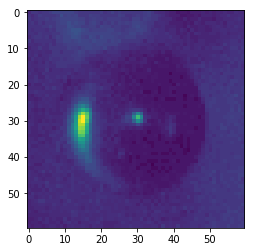

In [12]:
plt.imshow(green_subim[0])

## Red bubbles

In [13]:
radii = []
red_subim = []
res_circles = []
for tr in tracks:
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="constant")
            red_subim.append(subimg)            
            res_circles.append(res_circ)
            #radii += [res_circ.radius]

In [14]:
subimg = red_subim[2]

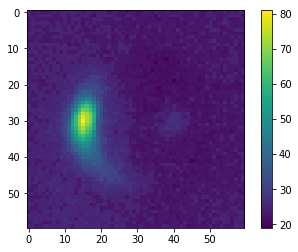

In [15]:
plt.imshow(red_subim[2])
plt.colorbar()

In [16]:
smooth_mask = gen_smooth_mask((30,30), [2,2])

In [17]:
res_circ = red_bubble_one(subimg, method="peak_dist", verbose=True)

#-#-#-#-#-#- new_bubble -#-#-#-#-#-#- [[30 15]]
first_peak_arg: 35
second_peak_arg 5
max_peak_x 45
second_peak_x 15


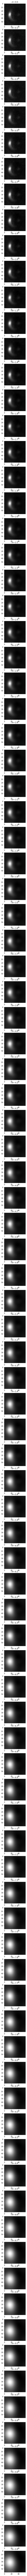

In [40]:
fig, ax = plt.subplots(len(sigma_list),1)
fig.set_figheight(300)
radii = []
sigma_list = np.arange(0, 10, 0.1)
for idx, sigma in enumerate(sigma_list):
    sm_subim = filters.gaussian(subimg, sigma)
    ax[idx].imshow(sm_subim,'gray')
    ax[idx].set_title("$\sigma =$" + str(sigma))
    #circ = res_circles[idx]
    #ax[idx].add_patch(plt.Circle((circ.y, circ.x), circ.radius, fill=False, color="red"))
    

In [41]:
radii = []
sigma_list = np.arange(0, 5, 0.1)
for sigma in sigma_list:
    sm_subim = filters.gaussian(subimg, sigma)
    res_circ = detec_bubble(subimg,
                            calib_radius_func=lambda x: x,
                            threshold_abs=50,
                            min_distance = 10,
                            classifier="bubble_forever",
                            output_shape="Circle",
                            signal_len=40,
                            flip_signal=True,
                            verbose=False)
    
    if isinstance(res_circ, Circle):
        radii += [res_circ.radius]
    elif isinstance(res_circ, list):
        radii += [rc.radius for rc in res_circ]

In [43]:
print(np.mean(radii))
print(np.std(radii))

15.0
0.0
